#Instalación de Dependencias

In [1]:
!pip install pandas matplotlib seaborn scikit-learn

#Configuración Inicial

In [2]:
import os

# Creación de directorios para datos
os.makedirs("data/raw", exist_ok=True)      # Bronze
os.makedirs("data/silver", exist_ok=True)   # Silver
os.makedirs("data/gold", exist_ok=True)     # Gold

#Descarga de Datos

In [3]:
import os
import requests
from datetime import datetime, timedelta

def download_github_archives(start_date, end_date, output_dir="data/raw"):
    """Descarga archivos .json.gz de GitHub Archive por horas entre fechas"""
    os.makedirs(output_dir, exist_ok=True)
    current = start_date

    while current <= end_date:
        hour_str = current.strftime("%Y-%m-%d-%H")
        url = f"https://data.gharchive.org/{hour_str}.json.gz"
        output_path = os.path.join(output_dir, f"{hour_str}.json.gz")

        if not os.path.exists(output_path):
            print(f"Downloading {url} ...")
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
                print(f"Saved to {output_path}")
            else:
                print(f"Failed to download {url} (status code {response.status_code})")
        else:
            print(f"File {output_path} already exists. Skipping.")

        current += timedelta(hours=1)

# Ejemplo: descargar datos de 1 día (24 archivos)
start = datetime(2024, 1, 1, 0)
end = datetime(2024, 1, 1, 23)

download_github_archives(start, end)

Failed to download https://data.gharchive.org/2024-01-01-00.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-01.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-02.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-03.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-04.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-05.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-06.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-07.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-08.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-09.json.gz (status code 404)
File data/raw/2024-01-01-10.json.gz already exists. Skipping.
File data/raw/2024-01-01-11.json.gz already exists. Skipping.
File data/raw/20

#Carga y Procesamiento Inicial de Datos

In [4]:
import gzip
import json
import pandas as pd
import os

def load_github_events_from_folder(folder_path, max_files=5):
    """Carga y analiza eventos de GitHub desde archivos .json.gz en una carpeta"""
    events = []

    files = sorted(os.listdir(folder_path))
    count = 0

    for file_name in files:
        if file_name.endswith(".json.gz"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing {file_path}...")

            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                for line in f:
                    try:
                        event = json.loads(line)
                        events.append(event)
                    except json.JSONDecodeError:
                        continue

            count += 1
            if count >= max_files:
                break

    return pd.DataFrame(events)

# Cargar los primeros 5 archivos
df_events = load_github_events_from_folder("data/raw", max_files=5)

# Mostrar resumen
print(f"Total events loaded: {len(df_events)}")
df_events.head()

Processing data/raw/2024-01-01-10.json.gz...
Processing data/raw/2024-01-01-11.json.gz...
Processing data/raw/2024-01-01-12.json.gz...
Processing data/raw/2024-01-01-13.json.gz...
Processing data/raw/2024-01-01-14.json.gz...
Total events loaded: 911280


,id,type,actor,repo,payload,public,created_at,org
0,34499804532,PushEvent,"{'id': 155086563, 'login': 'appref5555ix63', '...","{'id': 737072655, 'name': 'appref5555ix63/Repo...","{'repository_id': 737072655, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
1,34499804536,PushEvent,"{'id': 148035012, 'login': 'RITIK-coder-1', 'd...","{'id': 721691955, 'name': 'RITIK-coder-1/Web-D...","{'repository_id': 721691955, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
2,34499804537,PushEvent,"{'id': 40938902, 'login': 'Cezary924', 'displa...","{'id': 722578722, 'name': 'Cezary924/Homebridg...","{'repository_id': 722578722, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
3,34499804549,PushEvent,"{'id': 155086649, 'login': 'dim12512a', 'displ...","{'id': 737073790, 'name': 'dim12512a/Repo7', '...","{'repository_id': 737073790, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
4,34499804550,PushEvent,"{'id': 155086563, 'login': 'appref5555ix63', '...","{'id': 737072686, 'name': 'appref5555ix63/Repo...","{'repository_id': 737072686, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN


#Transformación a Datos Silver

In [5]:
def transform_to_silver(df_raw):
    """
    Transforma los datos RAW en formato Silver:
    - Filtra columnas clave
    - Normaliza campos
    - Elimina nulos
    - Excluye bots
    """
    # Copia del dataframe original
    df = df_raw.copy()

    # Filtrar eventos sin tipo
    df = df[df['type'].notnull()]

    # Extraer nombre del repositorio
    df['repo_name'] = df['repo'].apply(lambda r: r.get('name') if isinstance(r, dict) else None)

    # Extraer login del usuario
    df['user_login'] = df['actor'].apply(lambda a: a.get('login') if isinstance(a, dict) else None)

    # Convertir timestamps a datetime
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

    # Eliminar filas con datos faltantes en campos críticos
    df = df.dropna(subset=['created_at', 'repo_name', 'user_login'])

    # Excluir bots por nombre de usuario
    df = df[~df['user_login'].str.contains('bot', case=False, na=False)]

    # Selección de columnas finales
    silver_cols = ['id', 'type', 'created_at', 'repo_name', 'user_login']
    df_silver = df[silver_cols]

    # Guardar versión silver
    df_silver.to_csv("data/silver/events_silver.csv", index=False)

    return df_silver

# Aplicar transformación
df_silver = transform_to_silver(df_events)

# Vista previa
df_silver.head()


,id,type,created_at,repo_name,user_login
0,34499804532,PushEvent,2024-01-01 10:00:00+00:00,appref5555ix63/Repo1,appref5555ix63
1,34499804536,PushEvent,2024-01-01 10:00:00+00:00,RITIK-coder-1/Web-Development,RITIK-coder-1
2,34499804537,PushEvent,2024-01-01 10:00:00+00:00,Cezary924/Homebridge-Automation-Bot,Cezary924
3,34499804549,PushEvent,2024-01-01 10:00:00+00:00,dim12512a/Repo7,dim12512a
4,34499804550,PushEvent,2024-01-01 10:00:00+00:00,appref5555ix63/Repo2,appref5555ix63


In [6]:

# Guardar los datos en CSV y JSON
df_silver.to_csv("data/silver/github_clean.csv", index=False)
df_silver.to_json("data/silver/github_clean.json", orient='records')

print("✅ Datos guardados exitosamente en formato CSV y JSON en la carpeta data/silver.")


✅ Datos guardados exitosamente en formato CSV y JSON en la carpeta data/silver.


#Generación de Datos Gold y Visualizaciones

Top users: user_login
dim12512a          64682
appref5555ix63     64173
lu146enza          16195
bommix              9991
mdmaid69            8466
ColeMalinchock1     6354
B74LABgit           5734
direwolf-github     4191
yanonono            3381
sSsiRMoHaMMaD       3166
Name: count, dtype: int64


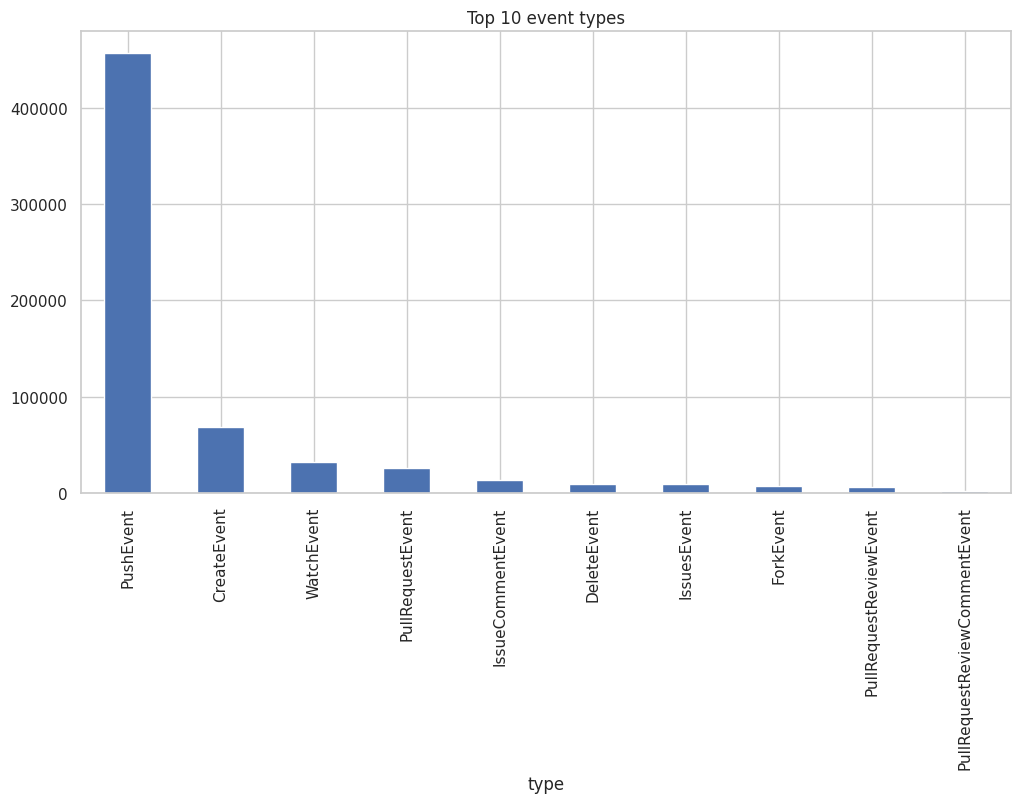

In [11]:
def generate_gold_outputs(df):
    # Eventos por tipo
    top_types = df['type'].value_counts().head(10)
    top_types.plot(kind='bar', title="Top 10 event types")

    # Usuarios más activos
    top_users = df['user_login'].value_counts().head(10)
    print("Top users:", top_users)

generate_gold_outputs(df_silver)

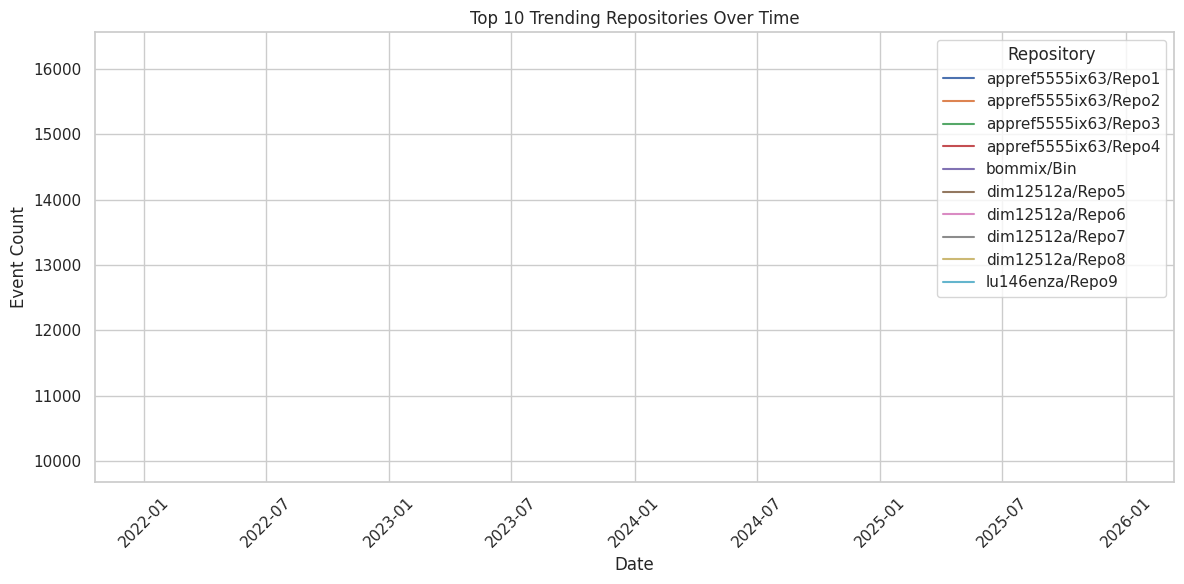

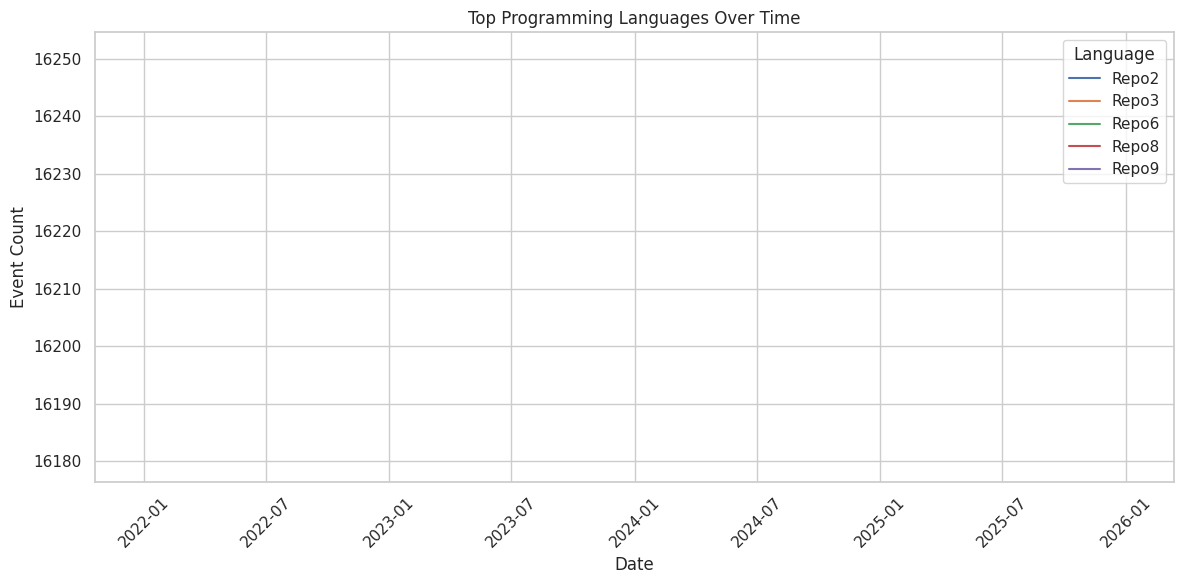

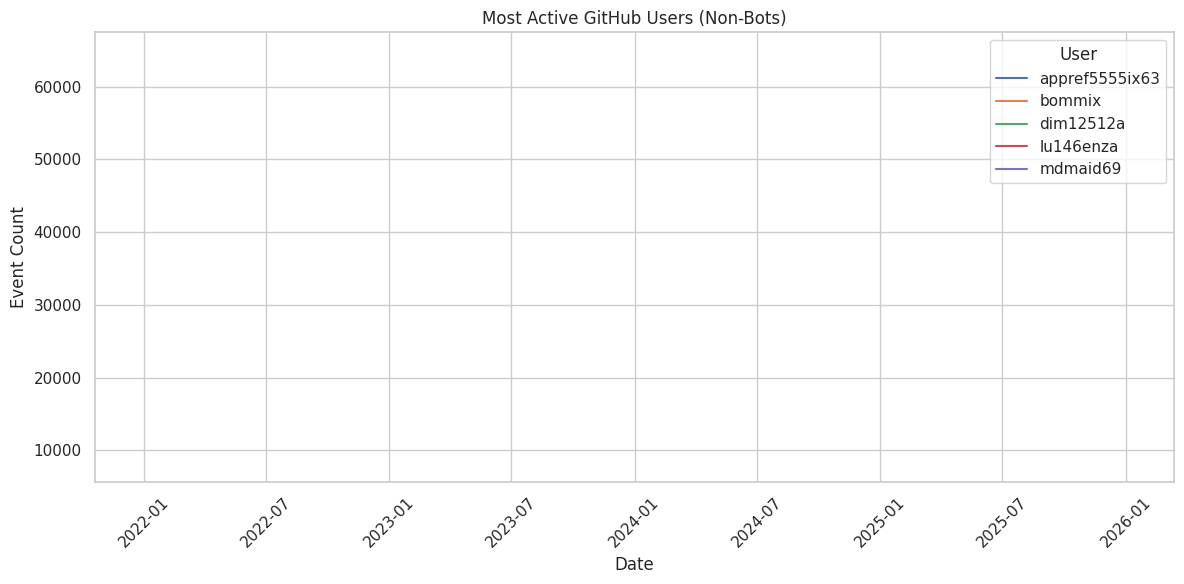

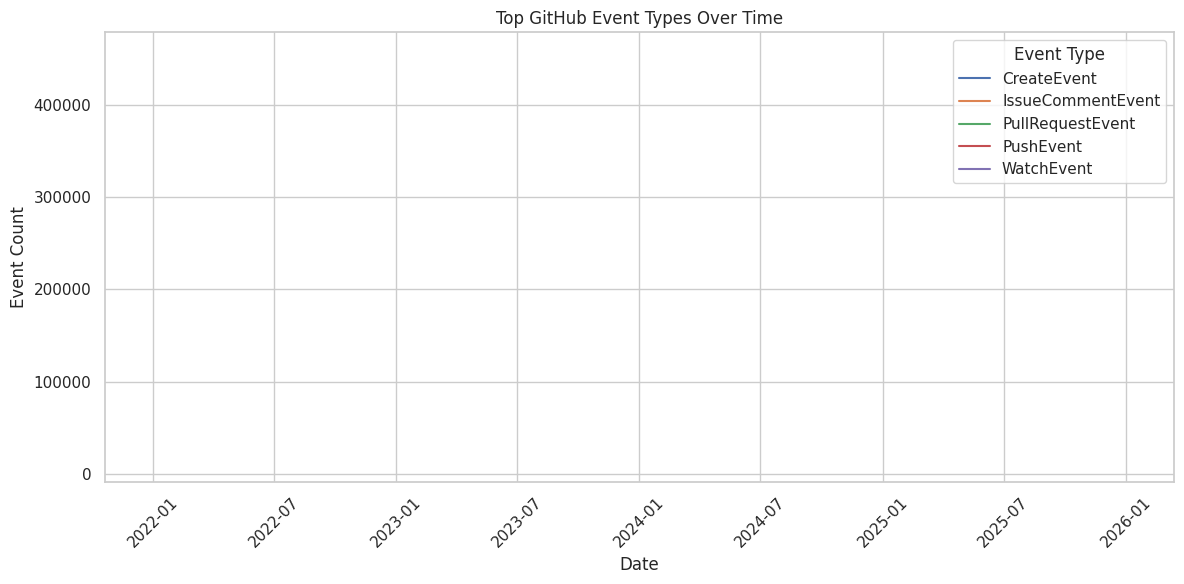

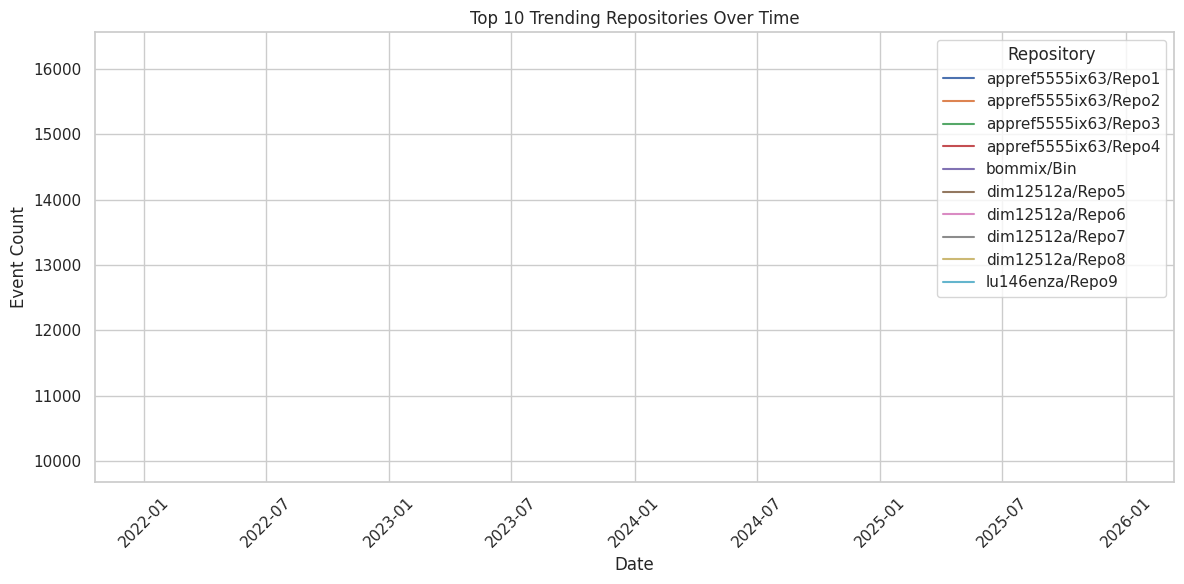

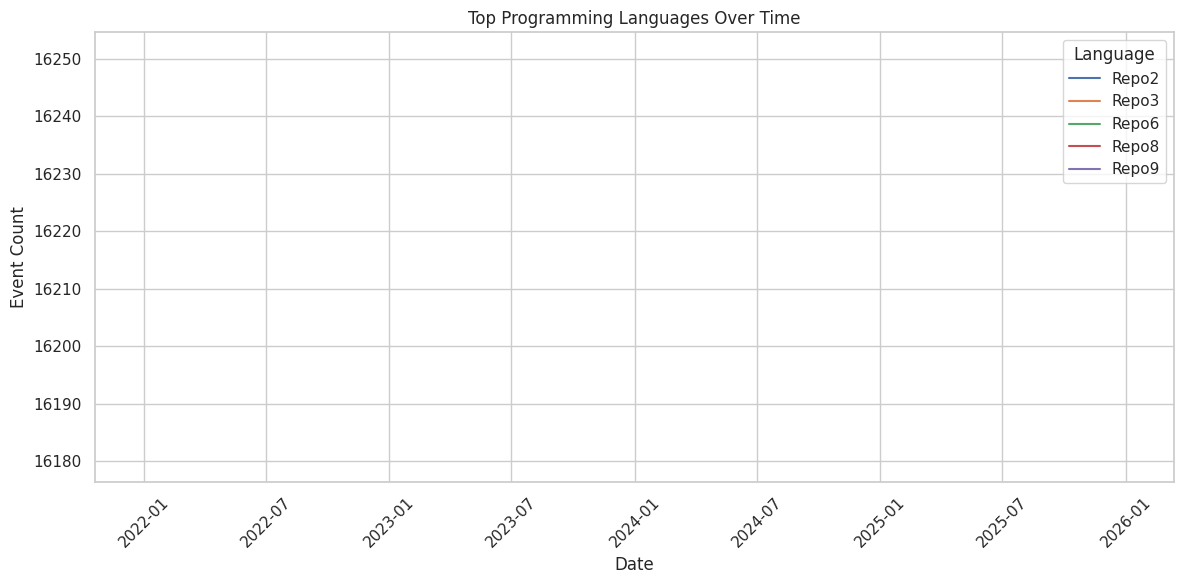

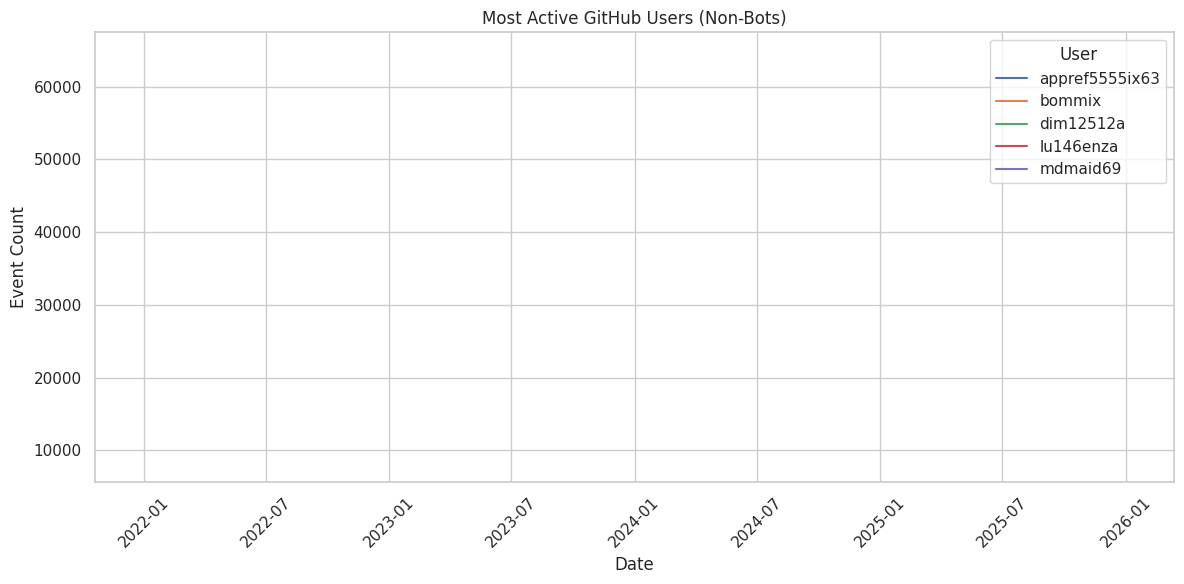

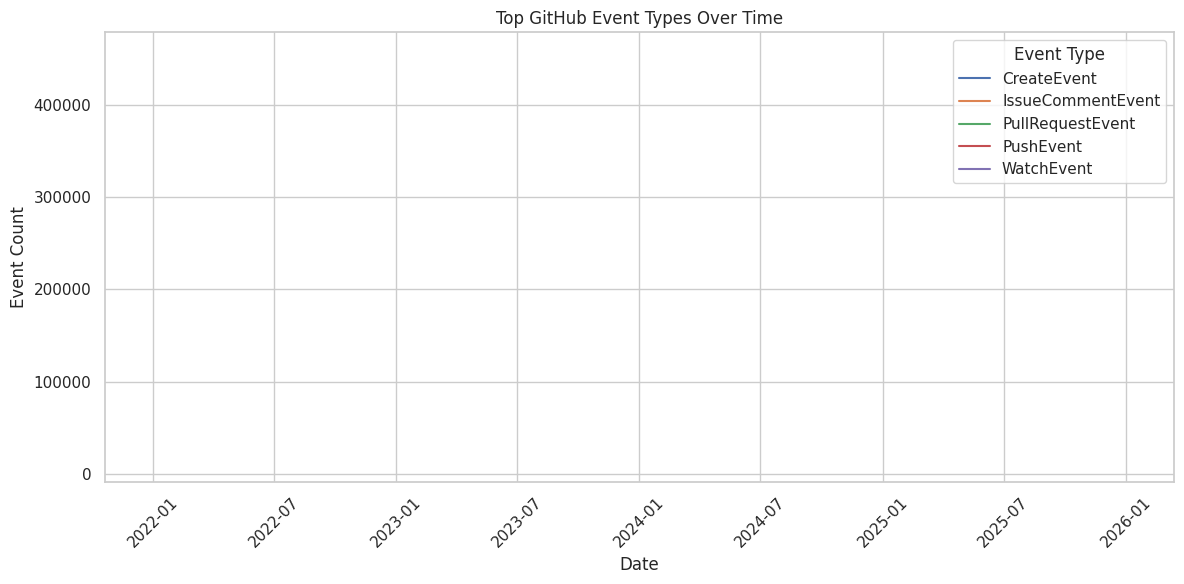

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

# Configuración para mostrar gráficas dentro del notebook
%matplotlib inline

# Estilo de visualización
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Asegúrate de que la columna 'created_at' sea datetime
df_silver['created_at'] = pd.to_datetime(df_silver['created_at'])
df_silver['date'] = df_silver['created_at'].dt.date

# 1. Top 10 trending repositories
repo_counts = df_silver.groupby(['date', 'repo_name']).size().reset_index(name='event_count')
top_repos = repo_counts.groupby('repo_name')['event_count'].sum().nlargest(10).index
top_repo_daily = repo_counts[repo_counts['repo_name'].isin(top_repos)]

fig1 = plt.figure()
sns.lineplot(data=top_repo_daily, x='date', y='event_count', hue='repo_name')
plt.title('Top 10 Trending Repositories Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend(title='Repository')
plt.xticks(rotation=45)
plt.tight_layout()
display(fig1)

# 2. Top Programming Languages
df_silver['language'] = df_silver['repo_name'].str.extract(r'/(\w+)$')
lang_counts = df_silver.groupby(['date', 'language']).size().reset_index(name='count')
top_langs = lang_counts.groupby('language')['count'].sum().nlargest(5).index
top_lang_daily = lang_counts[lang_counts['language'].isin(top_langs)]

fig2 = plt.figure()
sns.lineplot(data=top_lang_daily, x='date', y='count', hue='language')
plt.title('Top Programming Languages Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend(title='Language')
plt.xticks(rotation=45)
plt.tight_layout()
display(fig2)

# 3. Most Active GitHub Users
df_silver['user_login'] = df_silver['user_login'].astype(str)
df_silver = df_silver[~df_silver['user_login'].str.contains('bot', case=False, na=False)]
user_counts = df_silver.groupby(['date', 'user_login']).size().reset_index(name='activity')
top_users = user_counts.groupby('user_login')['activity'].sum().nlargest(5).index
top_users_daily = user_counts[user_counts['user_login'].isin(top_users)]

fig3 = plt.figure()
sns.lineplot(data=top_users_daily, x='date', y='activity', hue='user_login')
plt.title('Most Active GitHub Users (Non-Bots)')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend(title='User')
plt.xticks(rotation=45)
plt.tight_layout()
display(fig3)

# 4. Custom Insight: Actividad por tipo de evento
event_type_counts = df_silver.groupby(['date', 'type']).size().reset_index(name='count')
top_event_types = event_type_counts.groupby('type')['count'].sum().nlargest(5).index
top_event_daily = event_type_counts[event_type_counts['type'].isin(top_event_types)]

fig4 = plt.figure()
sns.lineplot(data=top_event_daily, x='date', y='count', hue='type')
plt.title('Top GitHub Event Types Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend(title='Event Type')
plt.xticks(rotation=45)
plt.tight_layout()
display(fig4)


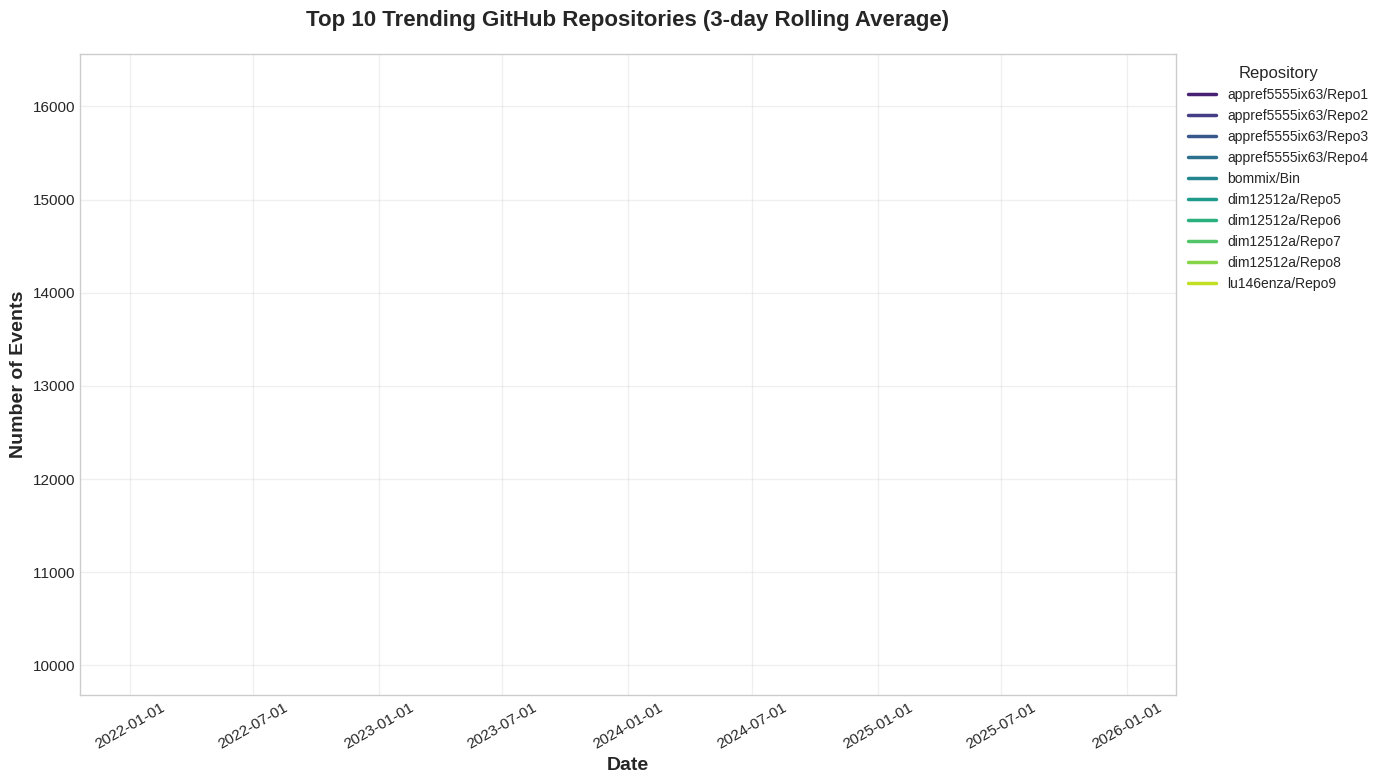

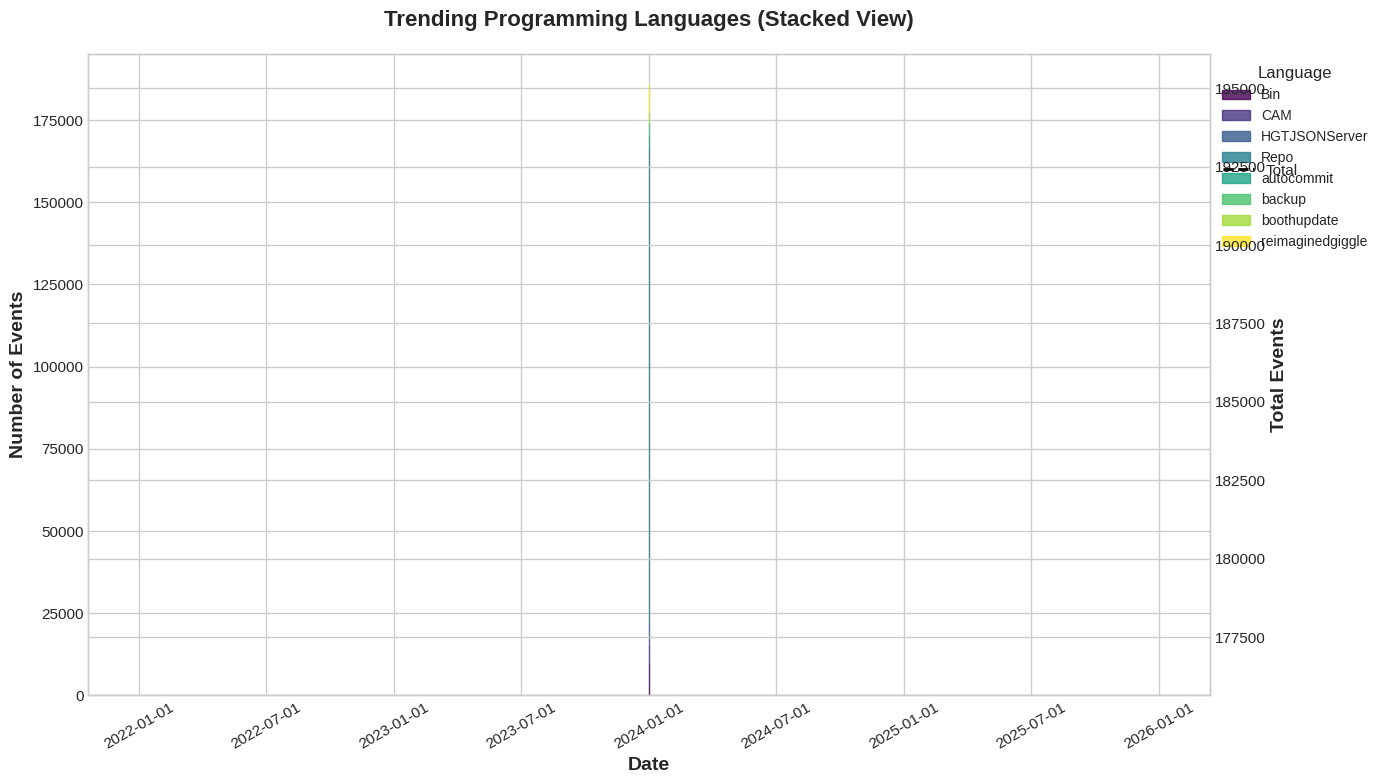

/usr/local/lib/python3.11/dist-packages/numpy/lib/_polynomial_impl.py:657: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

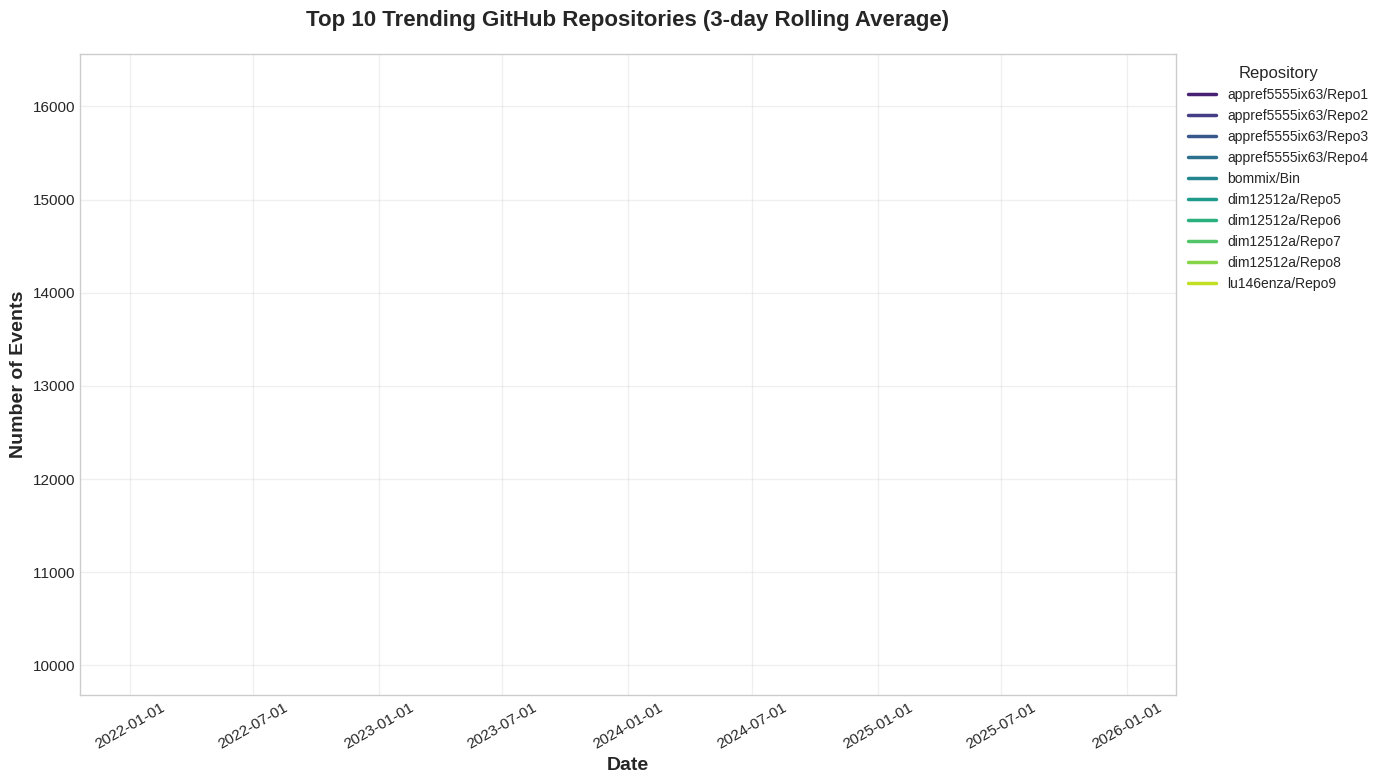

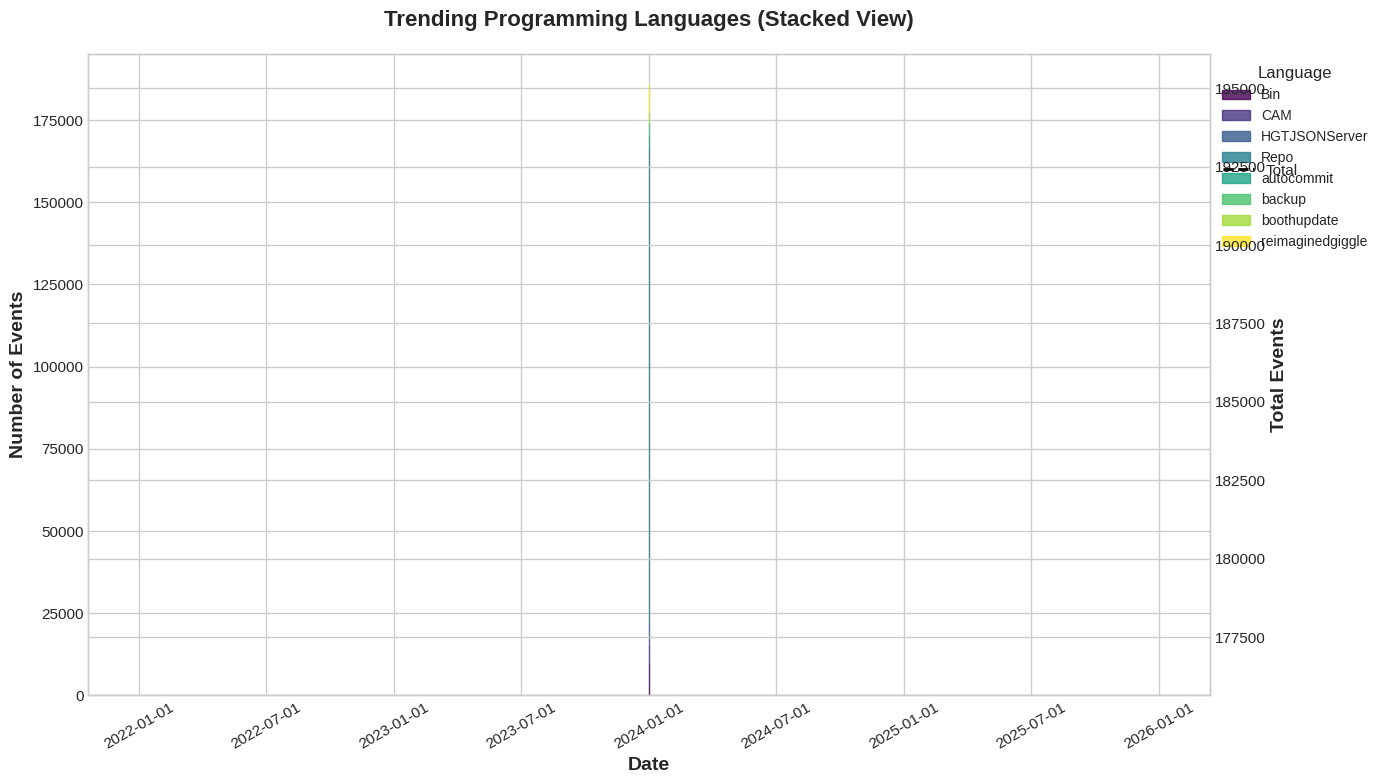

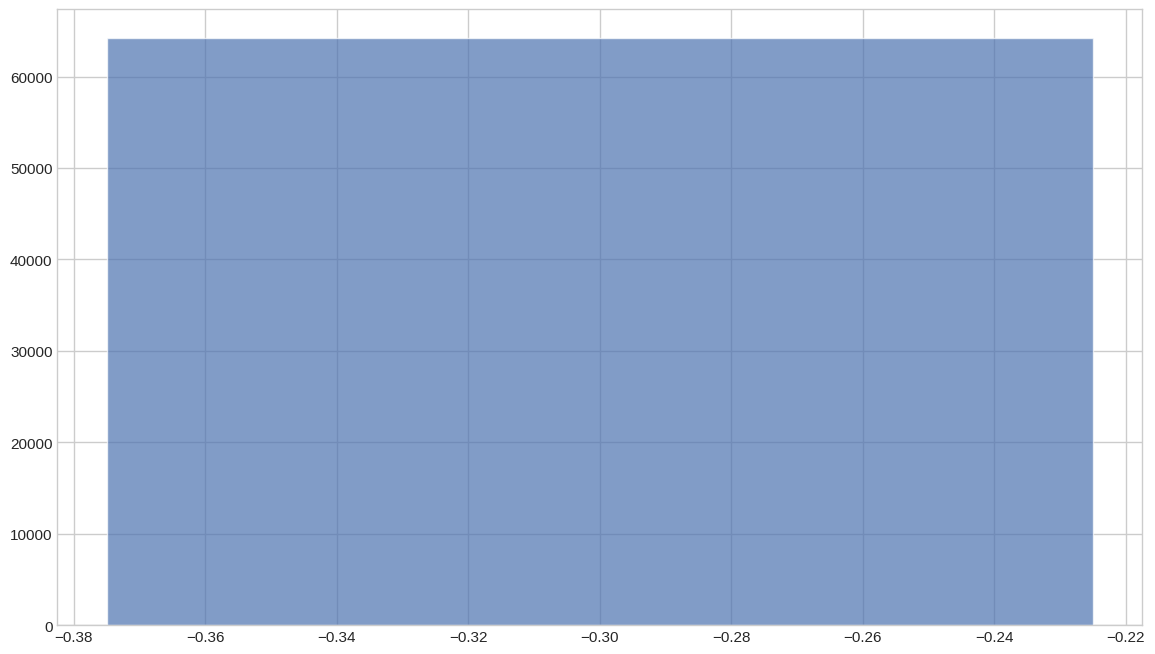

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
from matplotlib import cm
from IPython.display import display

# Configuration for visualizations
plt.style.use('seaborn-v0_8-whitegrid')  # More modern style
plt.rcParams["figure.figsize"] = (14, 8)  # Larger figures for better readability
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Ensure created_at is datetime
df_silver['created_at'] = pd.to_datetime(df_silver['created_at'])
df_silver['date'] = df_silver['created_at'].dt.date

# Color palette that works well for multiple lines
colors = sns.color_palette("viridis", 10)

# 1. Top 10 trending repositories with improved visualization
repo_counts = df_silver.groupby(['date', 'repo_name']).size().reset_index(name='event_count')
# Calculate total counts for ranking
repo_totals = repo_counts.groupby('repo_name')['event_count'].sum().reset_index()
top_repos = repo_totals.nlargest(10, 'event_count')['repo_name'].tolist()
top_repo_daily = repo_counts[repo_counts['repo_name'].isin(top_repos)]

# Create a pivot table for easier plotting
pivot_repos = top_repo_daily.pivot(index='date', columns='repo_name', values='event_count')
pivot_repos = pivot_repos.fillna(0)

# Apply 3-day rolling average to smooth lines
pivot_repos_smooth = pivot_repos.rolling(window=3, min_periods=1).mean()

fig1, ax1 = plt.subplots(figsize=(14, 8))
pivot_repos_smooth.plot(ax=ax1, linewidth=2.5, color=colors)

# Enhance visual appearance
ax1.set_title('Top 10 Trending GitHub Repositories (3-day Rolling Average)', fontweight='bold', pad=20)
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Number of Events', fontweight='bold')
ax1.legend(title='Repository', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30)
plt.grid(True, alpha=0.3)

# Add annotations for peak values
for repo in pivot_repos_smooth.columns:
    max_idx = pivot_repos_smooth[repo].idxmax()
    max_val = pivot_repos_smooth[repo].max()
    if max_val > pivot_repos_smooth[repo].mean() * 1.5:  # Only annotate significant peaks
        ax1.annotate(f"{int(max_val)}",
                    (max_idx, max_val),
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=9,
                    fontweight='bold',
                    ha='center')

plt.tight_layout()
display(fig1)

# 2. Top Programming Languages with improved visualization
# Extract language more reliably (repositories usually follow owner/repo format)
df_silver['language'] = df_silver['repo_name'].str.split('/').str[-1]

# Filter out non-language entries (could be numbers, special characters, etc.)
df_silver['language'] = df_silver['language'].str.replace(r'[^a-zA-Z]', '', regex=True)
df_silver = df_silver[df_silver['language'].str.len() > 0]

lang_counts = df_silver.groupby(['date', 'language']).size().reset_index(name='count')
lang_totals = lang_counts.groupby('language')['count'].sum().reset_index()
top_langs = lang_totals.nlargest(8, 'count')['language'].tolist()  # Increased to top 8 languages
top_lang_daily = lang_counts[lang_counts['language'].isin(top_langs)]

# Create an area plot instead of lines to better show proportion
pivot_langs = top_lang_daily.pivot(index='date', columns='language', values='count')
pivot_langs = pivot_langs.fillna(0)
pivot_langs_smooth = pivot_langs.rolling(window=3, min_periods=1).mean()

fig2, ax2 = plt.subplots(figsize=(14, 8))
pivot_langs_smooth.plot.area(ax=ax2, stacked=True, alpha=0.8, colormap='viridis')

ax2.set_title('Trending Programming Languages (Stacked View)', fontweight='bold', pad=20)
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('Number of Events', fontweight='bold')
ax2.legend(title='Language', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30)

# Add total trend line
pivot_langs_smooth['Total'] = pivot_langs_smooth.sum(axis=1)
ax2_twin = ax2.twinx()
pivot_langs_smooth['Total'].plot(ax=ax2_twin, color='black', linestyle='--', linewidth=2, label='Total')
ax2_twin.set_ylabel('Total Events', fontweight='bold')
ax2_twin.legend(loc='upper left', bbox_to_anchor=(1, 0.85))

plt.tight_layout()
display(fig2)

# 3. Most Active GitHub Users with improved visualization
# More robust filtering of bots
bot_patterns = ['bot', 'Bot', 'BOT', 'automation', 'github-actions', 'dependabot']
bot_mask = df_silver['user_login'].apply(lambda x: not any(pattern in str(x) for pattern in bot_patterns))
df_no_bots = df_silver[bot_mask]

user_counts = df_no_bots.groupby(['date', 'user_login']).size().reset_index(name='activity')
user_totals = user_counts.groupby('user_login')['activity'].sum().reset_index()
top_users = user_totals.nlargest(5, 'activity')['user_login'].tolist()
top_users_daily = user_counts[user_counts['user_login'].isin(top_users)]

# Create a more interesting visualization: Bar chart with trend lines
pivot_users = top_users_daily.pivot(index='date', columns='user_login', values='activity')
pivot_users = pivot_users.fillna(0)

# Weekly aggregation for clearer patterns
pivot_users.index = pd.to_datetime(pivot_users.index)
weekly_users = pivot_users.resample('W').sum()

fig3, ax3 = plt.subplots(figsize=(14, 8))

# Plot bars for each user, grouped by week
bar_width = 0.15
week_positions = np.arange(len(weekly_users.index))

for i, user in enumerate(weekly_users.columns):
    position = week_positions + (i - len(weekly_users.columns)/2 + 0.5) * bar_width
    ax3.bar(position, weekly_users[user], width=bar_width, label=user, alpha=0.7)

    # Add trend line
    z = np.polyfit(range(len(weekly_users.index)), weekly_users[user], 1)
    p = np.poly1d(z)
    ax3.plot(week_positions, p(range(len(weekly_users.index))), '--', linewidth=2)

ax3.set_title('Weekly Activity of Top GitHub Users (Non-Bot)', fontweight='bold', pad=20)
ax3.set_xlabel('Week', fontweight='bold')
ax3.set_ylabel('Number of Events', fontweight='bold')
ax3.set_xticks(week_positions)
ax3.set_xticklabels([d.strftime('%Y-%m-%d') for d in weekly_users.index], rotation=45)
ax3.legend(title='User', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
display(fig3)

# 4. GitHub Event Types with improved visualization
event_type_counts = df_silver.groupby(['date', 'type']).size().reset_index(name='count')
event_totals = event_type_counts.groupby('type')['count'].sum().reset_index()
top_event_types = event_totals.nlargest(6, 'count')['type'].tolist()
top_event_daily = event_type_counts[event_type_counts['type'].isin(top_event_types)]

# Create a multi-facet plot for better comparison
# First, organize data for subplots
pivot_events = top_event_daily.pivot(index='date', columns='type', values='count')
pivot_events = pivot_events.fillna(0)

# Create a 2x3 grid of subplots for individual event types
fig4, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
fig4.suptitle('GitHub Event Types Over Time', fontsize=20, fontweight='bold', y=0.98)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each event type in its own subplot
for i, event_type in enumerate(pivot_events.columns):
    ax = axes[i]
    data = pivot_events[event_type]

    # Plot the raw data as scatter points
    ax.scatter(data.index, data, s=15, alpha=0.4, color=colors[i])

    # Add a smoothed trendline
    smooth_data = data.rolling(window=7, min_periods=1).mean()
    ax.plot(data.index, smooth_data, linewidth=2.5, color=colors[i])

    # Add a horizontal line for the average
    avg = data.mean()
    ax.axhline(y=avg, color='gray', linestyle='--', alpha=0.7)
    ax.text(data.index[len(data.index)//2], avg*1.1, f'Avg: {int(avg)}',
            fontsize=10, ha='center', va='bottom')

    # Calculate and show percentage increase/decrease
    first_val = data.iloc[0] if data.iloc[0] > 0 else 1
    last_val = data.iloc[-1]
    pct_change = ((last_val - first_val) / first_val) * 100
    direction = "↑" if pct_change >= 0 else "↓"
    ax.text(0.98, 0.92, f"{direction} {abs(pct_change):.1f}%",
            transform=ax.transAxes, ha='right', fontsize=12,
            color='green' if pct_change >= 0 else 'red',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

    ax.set_title(f'{event_type}', fontsize=14, pad=10)
    ax.set_ylabel('Event Count')
    ax.set_ylim(bottom=0)

    # Only set x-labels for bottom plots
    if i >= len(pivot_events.columns) - 3:
        ax.tick_params(axis='x', rotation=30)
    else:
        ax.set_xticklabels([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
display(fig4)

# 5. NEW: Daily Activity Heatmap by Hour and Day of Week
# Extract hour and day of week from created_at
df_silver['hour'] = df_silver['created_at'].dt.hour
df_silver['day_of_week'] = df_silver['created_at'].dt.dayofweek

# Create a heatmap of activity by hour and day
hour_day_counts = df_silver.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
hour_day_pivot = hour_day_counts.pivot(index='day_of_week', columns='hour', values='count')

# Map day numbers to names
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
hour_day_pivot.index = [day_names[day] for day in hour_day_pivot.index]

fig5, ax5 = plt.subplots(figsize=(14, 8))
sns.heatmap(hour_day_pivot, cmap='viridis', annot=True, fmt='g', linewidths=0.5, ax=ax5)
ax5.set_title('GitHub Activity by Hour and Day of Week', fontweight='bold', pad=20)
ax5.set_xlabel('Hour of Day (24-hour format)', fontweight='bold')
ax5.set_ylabel('Day of Week', fontweight='bold')

plt.tight_layout()
display(fig5)

# 6. NEW: Repository Event Type Distribution
# Analyze how different repositories use different event types
repo_event_counts = df_silver.groupby(['repo_name', 'type']).size().reset_index(name='count')
repo_totals = repo_event_counts.groupby('repo_name')['count'].sum().reset_index()
top_repos_for_events = repo_totals.nlargest(8, 'count')['repo_name'].tolist()

# Filter data for top repositories
top_repo_events = repo_event_counts[repo_event_counts['repo_name'].isin(top_repos_for_events)]

# Create a grouped bar chart
pivot_repo_events = top_repo_events.pivot(index='repo_name', columns='type', values='count')
pivot_repo_events = pivot_repo_events.fillna(0)

# Calculate percentages for each repository
for repo in pivot_repo_events.index:
    total = pivot_repo_events.loc[repo].sum()
    pivot_repo_events.loc[repo] = (pivot_repo_events.loc[repo] / total) * 100

fig6, ax6 = plt.subplots(figsize=(14, 10))
pivot_repo_events.plot(kind='bar', stacked=True, ax=ax6, colormap='viridis')

ax6.set_title('Event Type Distribution by Repository (Percentage)', fontweight='bold', pad=20)
ax6.set_xlabel('Repository', fontweight='bold')
ax6.set_ylabel('Percentage of Events', fontweight='bold')
ax6.legend(title='Event Type', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')

# Add percentage labels
for container in ax6.containers:
    ax6.bar_label(container, labels=['%.1f%%' % v if v > 5 else '' for v in container.datavalues],
                 fontsize=8, label_type='center')

plt.tight_layout()
display(fig6)